# Gaussian Mixture Model

Original NB by Abe Flaxman, modified by Thomas Wiecki


In [1]:
!date
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

print('Running on PyMC3 v{}'.format(pm.__version__))

Fri 12 Jun 2020 07:12:54 PM UTC
Running on PyMC3 v3.9.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

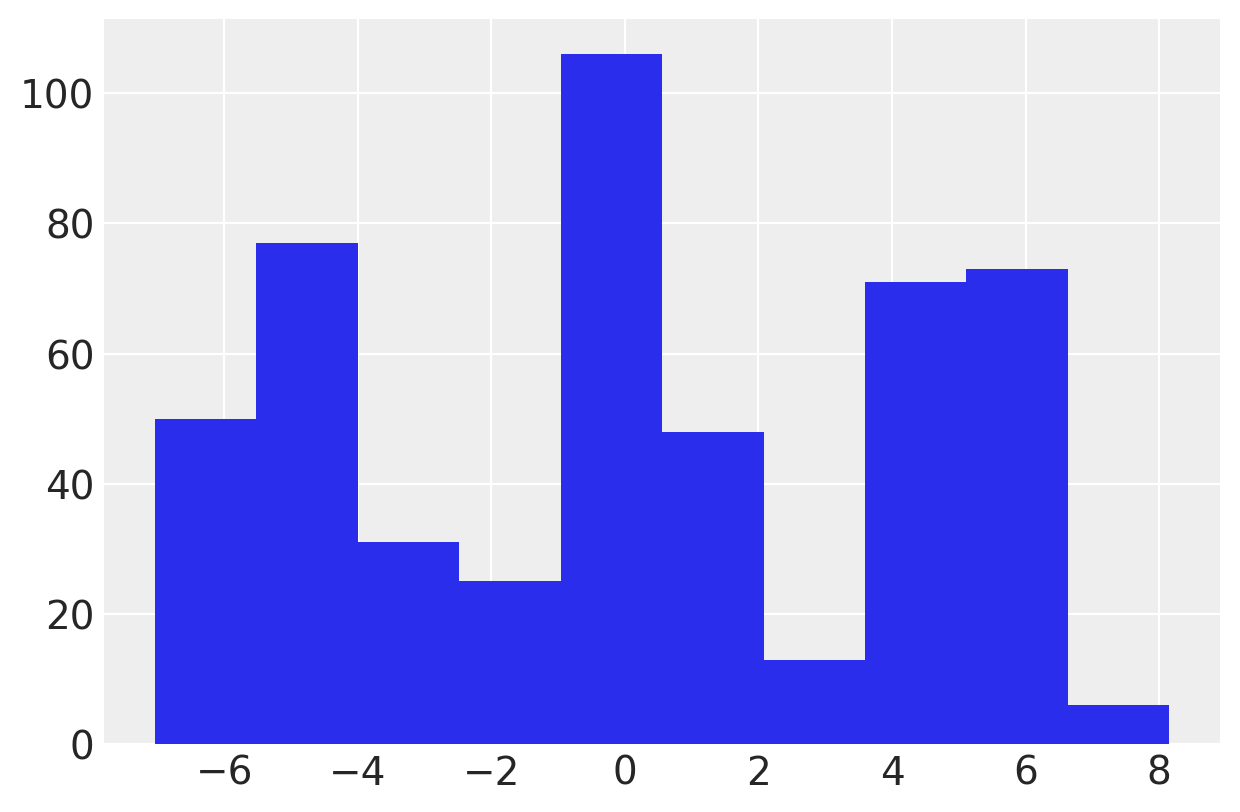

In [3]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [4]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sigma=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
    
    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sigma=sd,
                       observed=data)

In [5]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    tr = pm.sample(10000, step=[step1, step2], tune=5000)

/env/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd]
>>Metropolis: [p]
>ElemwiseCategorical: [category]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 394 seconds.
The number of effective samples is smaller than 10% for some parameters.


## Full trace

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


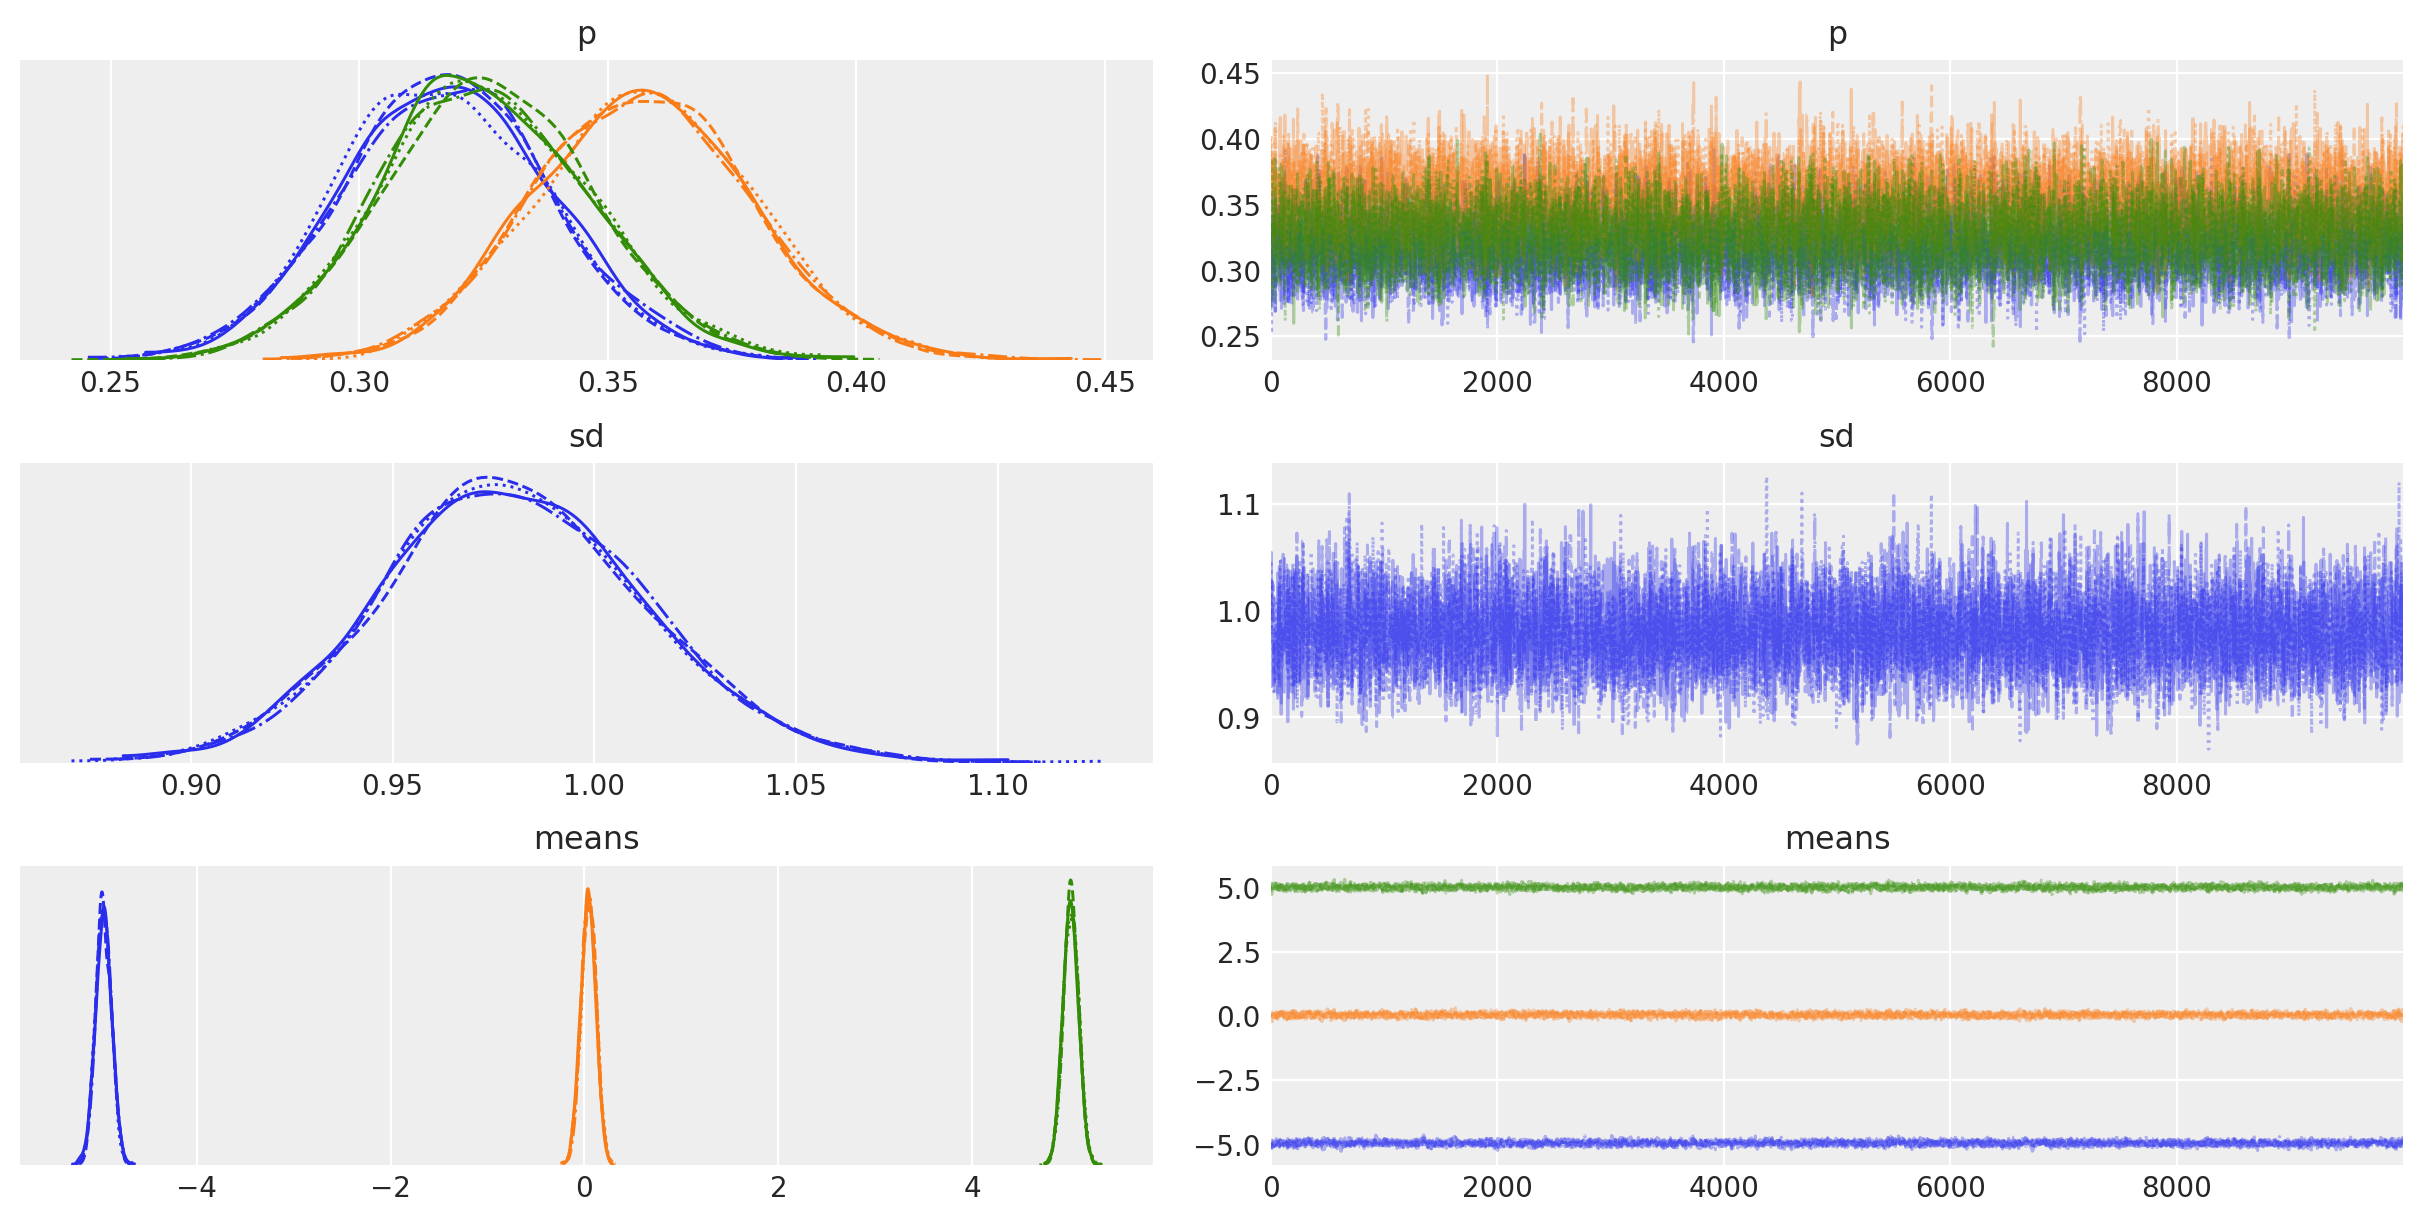

In [6]:
pm.traceplot(tr, var_names=['p', 'sd', 'means']);

## After convergence

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


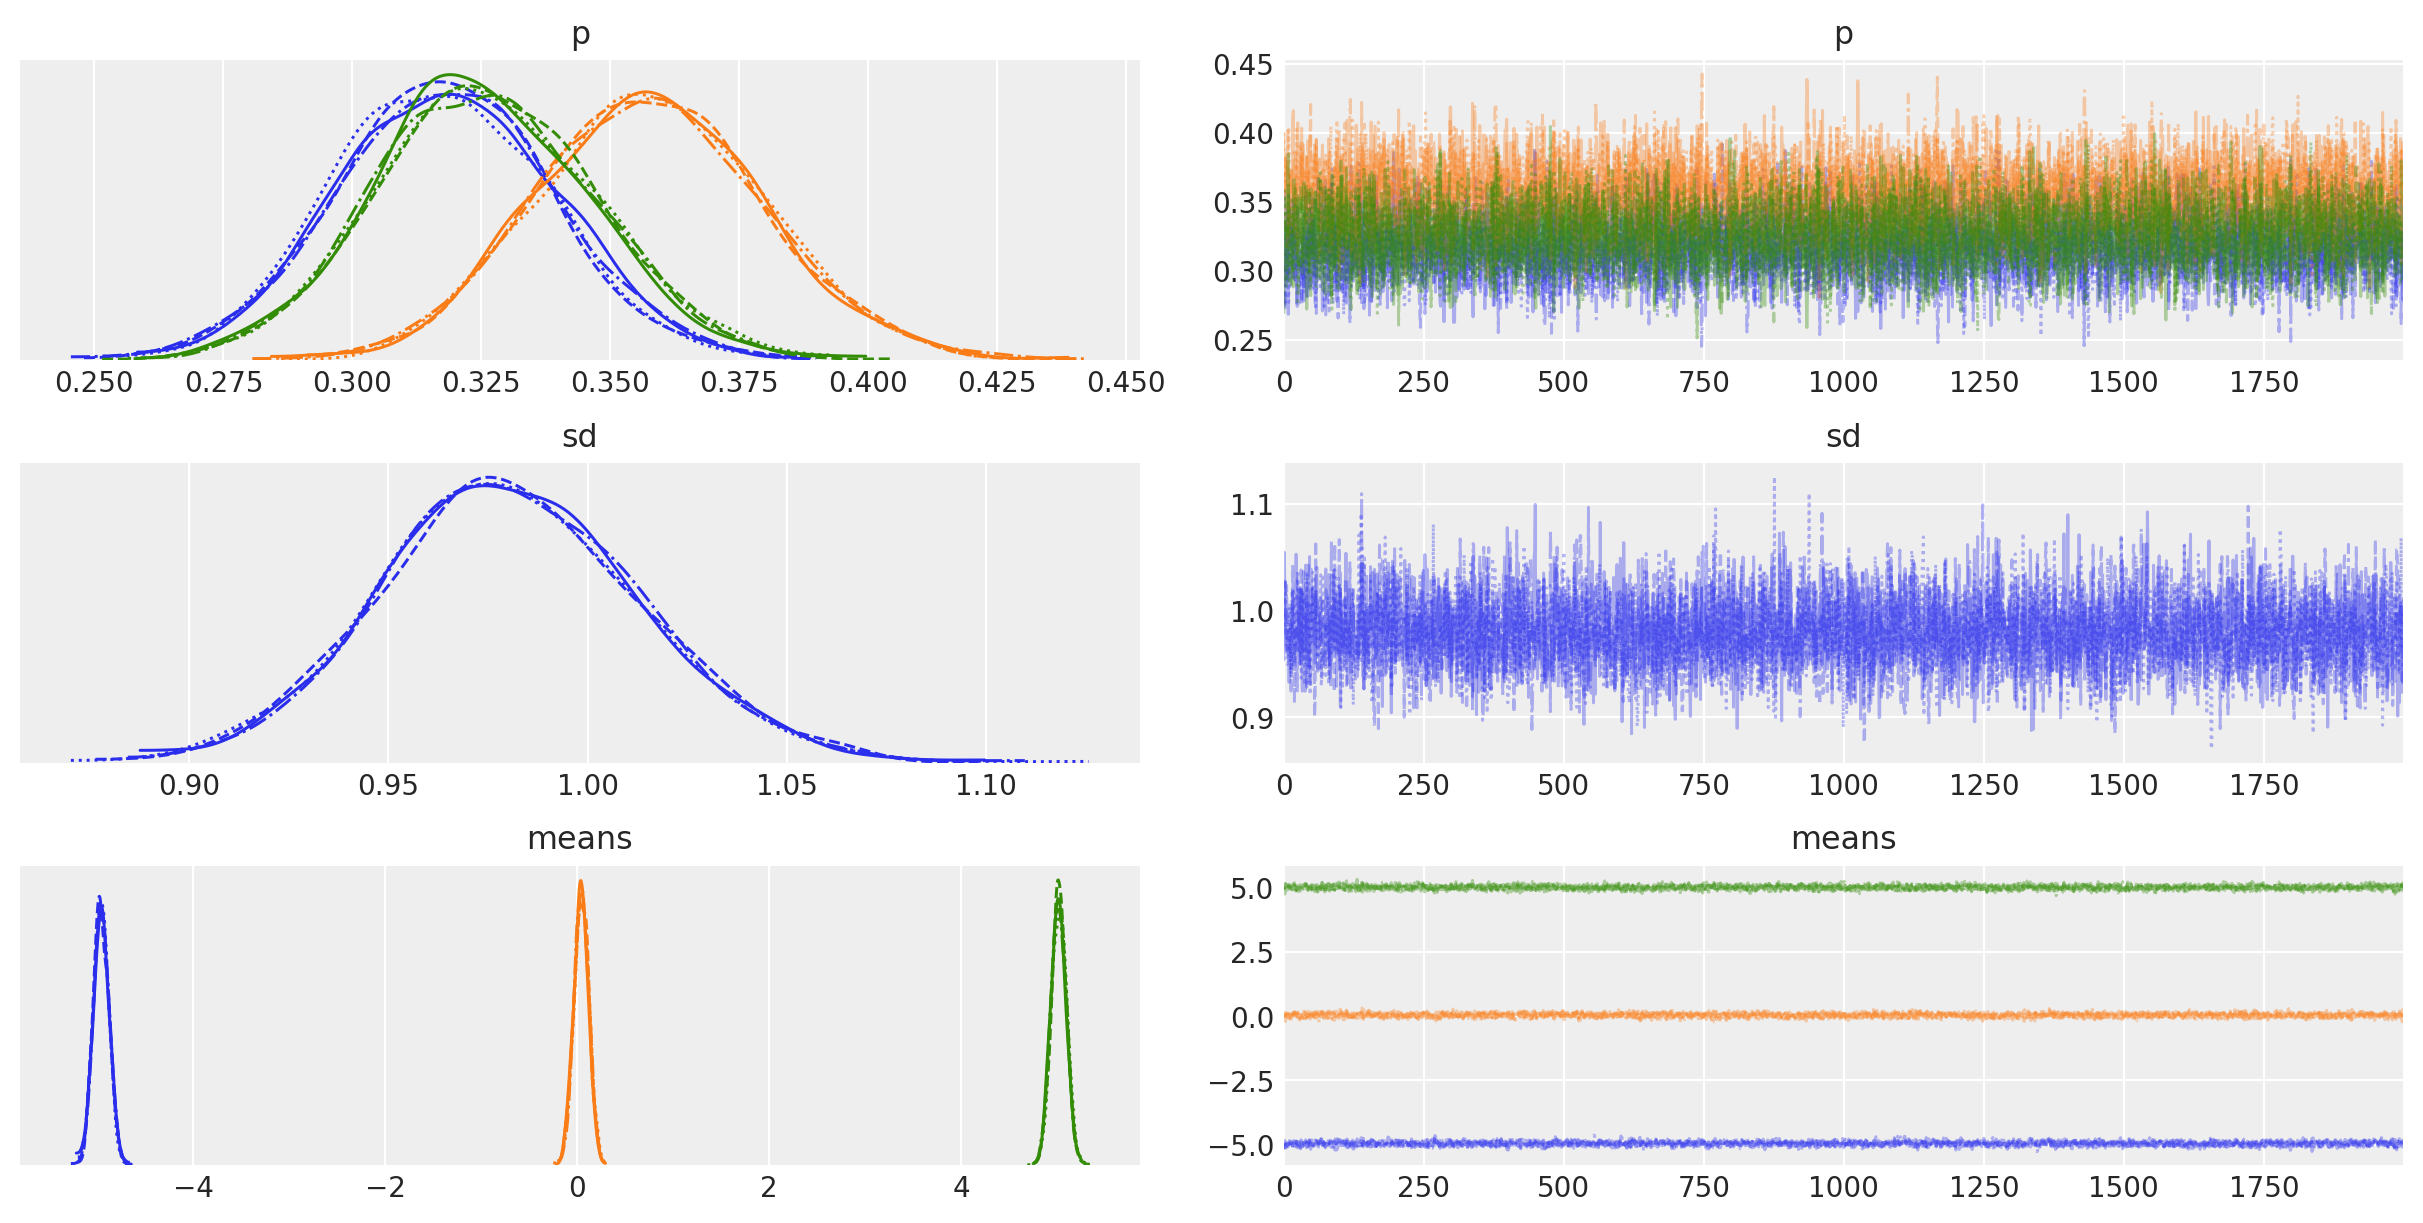

In [7]:
# take a look at traceplot for some model parameters
pm.plots.traceplot(tr[::5], var_names=['p', 'sd', 'means']);

/dependencies/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


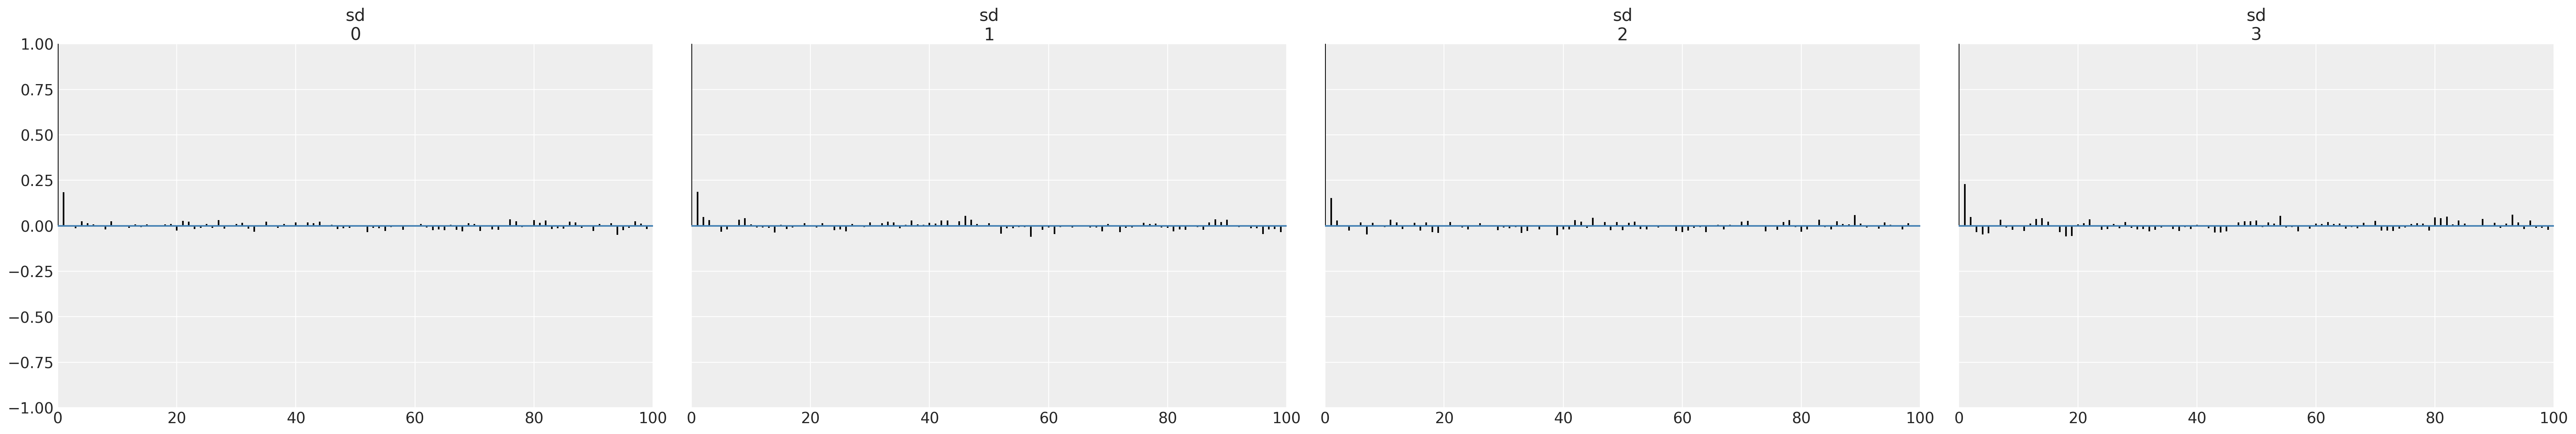

In [8]:
# I prefer autocorrelation plots for serious confirmation of MCMC convergence
pm.autocorrplot(tr[::5], var_names=['sd']);

## Sampling of cluster for individual data point

(-399.95000000000005, 8398.95, -0.1, 2.1)

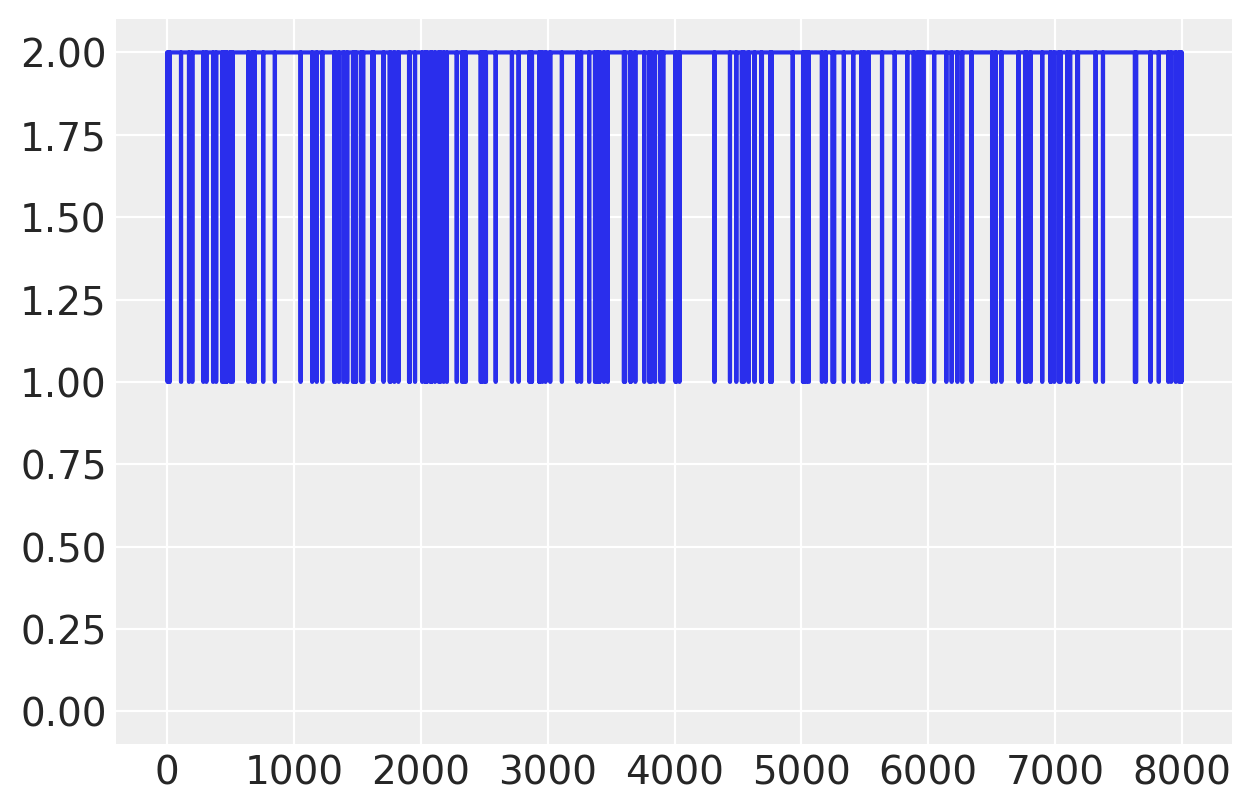

In [9]:
i=0
plt.plot(tr['category'][::5, i], drawstyle='steps-mid')
plt.axis(ymin=-.1, ymax=2.1)

true cluster: 2
  data value: 3.29


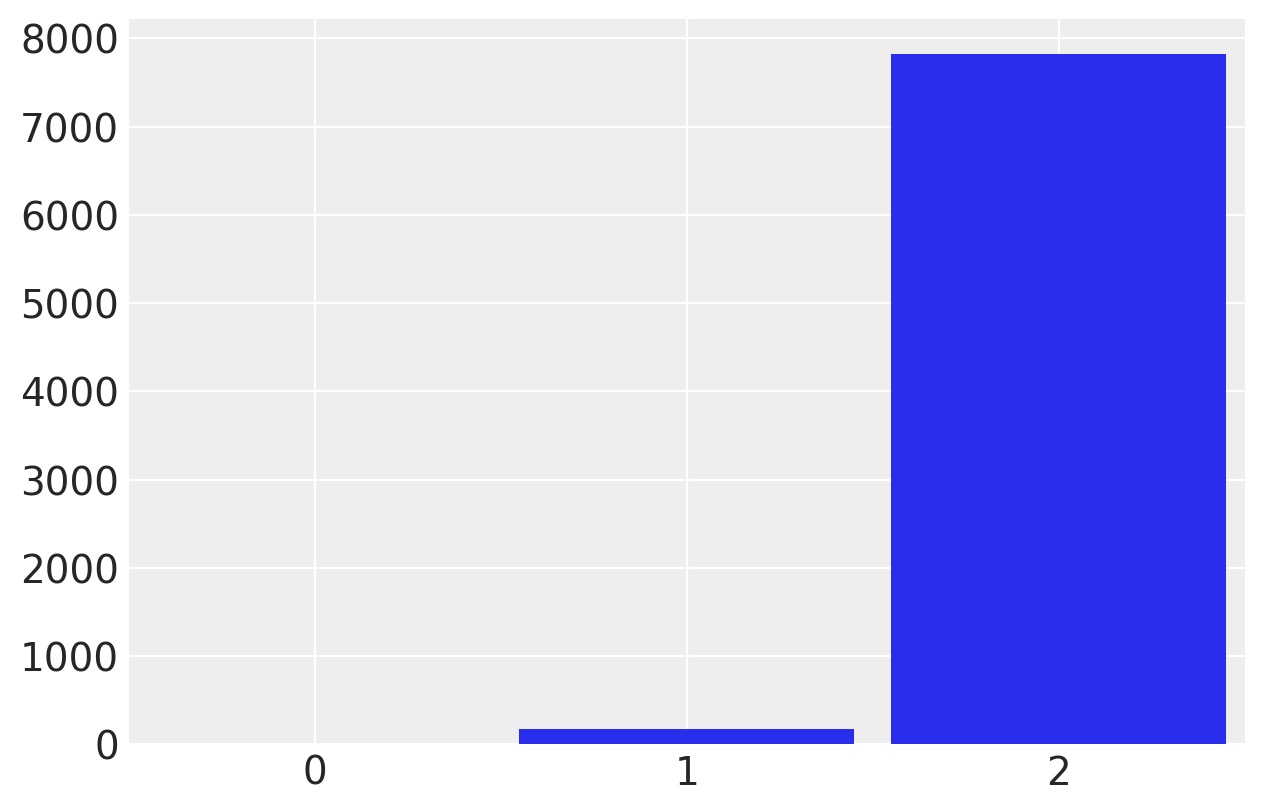

In [10]:
def cluster_posterior(i=0):
    print('true cluster:', v[i])
    print('  data value:', np.round(data[i],2))
    plt.hist(tr['category'][::5,i], bins=[-.5,.5,1.5,2.5,], rwidth=.9)
    plt.axis(xmin=-.5, xmax=2.5)
    plt.xticks([0,1,2])
cluster_posterior(i)

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz  0.8.3
numpy  1.18.5
pymc3  3.9.0
pandas 1.0.4
last updated: Fri Jun 12 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
